Yesterday, I read this [recent article on medium about facial keypoint detection](https://medium.com/towards-data-science/detecting-facial-features-using-deep-learning-2e23c8660a7a). The article suggests that deep learning methods can easily be used to perform this task. It ends by suggesting that everyone should try it, since the data needed and the toolkits are all open source. This article is my attempt, since I've been interested in face detection for a long time and [written about it before](http://flothesof.github.io/smile-recognition.html).

This is the outline of what we'll try:

- loading the data
- analyzing the data
- building a Keras model
- checking the results
- applying the method to a fun problem 

# Loading the data 

The data we will use comes from a [Kaggle challenge](https://www.kaggle.com/c/facial-keypoints-detection#description) called *Facial Keypoints Detection*. I've downloaded the *.csv* file and put it in a *data/* directory. Let's use pandas to read it.

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('vehiclereid_baseline/test1.txt', sep=",", header=None)

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,VeRi/image_train/0181_c001_00034295_0.jpg,-1,-1,-1,-1,367,89,190,205,-1,...,77,14,148,91,180,44,160,46,176,7
1,VeRi/image_train/0181_c001_00034315_0.jpg,-1,-1,-1,-1,231,58,153,132,-1,...,32,14,94,108,108,55,100,58,114,7
2,VeRi/image_train/0181_c001_00034340_0.jpg,-1,-1,-1,-1,130,56,114,92,-1,...,19,18,64,96,69,55,62,54,72,7
3,VeRi/image_train/0181_c012_00034760_0.jpg,-1,-1,-1,-1,213,71,163,141,-1,...,44,22,100,123,113,67,106,70,123,7
4,VeRi/image_train/0181_c012_00034765_0.jpg,-1,-1,-1,-1,192,66,151,124,-1,...,36,25,89,116,97,68,93,73,108,7


In [5]:
df.shape

(499, 42)

# Analyzing the data 

The `Image` column contains the face data for which the 30 first columns represent the keypoint data (15 x-coordinates and 15 y-coordinates). Let's try to get a feel for the data. First, let's display some faces.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [40]:
def string2image(string):
    """Converts a string to a numpy array."""
    img = cv2.imread(string)
    #img = cv2.resize(img,(336,336))
    return img
    #return np.array([int(item) for item in string.split()]).reshape((96, 96))

def plot_faces(nrows=5, ncols=5):
    """Randomly displays some faces from the training data."""
    selection = np.random.choice(df.index, size=(nrows*ncols), replace=False)
    image_strings = df.loc[selection][0]
    fig, axes = plt.subplots(figsize=(10, 10), nrows=nrows, ncols=ncols)
    for string, ax in zip(image_strings, axes.ravel()):
        print(string)
        ax.imshow(string2image(string), cmap='gray')
        ax.axis('off')

VeRi/image_train/0181_c014_00036570_0.jpg
VeRi/image_train/0185_c009_00042525_0.jpg
VeRi/image_train/0185_c008_00042440_0.jpg
VeRi/image_train/0189_c010_00003830_0.jpg
VeRi/image_train/0191_c017_00031640_0.jpg
VeRi/image_train/0297_c014_00077460_0.jpg
VeRi/image_train/0293_c006_00001500_0.jpg
VeRi/image_train/0181_c013_00034610_0.jpg
VeRi/image_train/0190_c014_00005570_0.jpg
VeRi/image_train/0293_c009_00000425_0.jpg
VeRi/image_train/0184_c015_00016750_0.jpg
VeRi/image_train/0189_c017_00000755_0.jpg
VeRi/image_train/0287_c001_00033100_0.jpg
VeRi/image_train/0287_c001_00033080_0.jpg
VeRi/image_train/0297_c015_00068010_0.jpg
VeRi/image_train/0190_c017_00072295_0.jpg
VeRi/image_train/0181_c014_00036580_0.jpg
VeRi/image_train/0191_c019_00031820_0.jpg
VeRi/image_train/0191_c010_00027390_0.jpg
VeRi/image_train/0289_c002_00049960_0.jpg
VeRi/image_train/0181_c012_00034775_0.jpg
VeRi/image_train/0190_c019_00004155_0.jpg
VeRi/image_train/0194_c003_00052155_0.jpg
VeRi/image_train/0185_c010_0004303

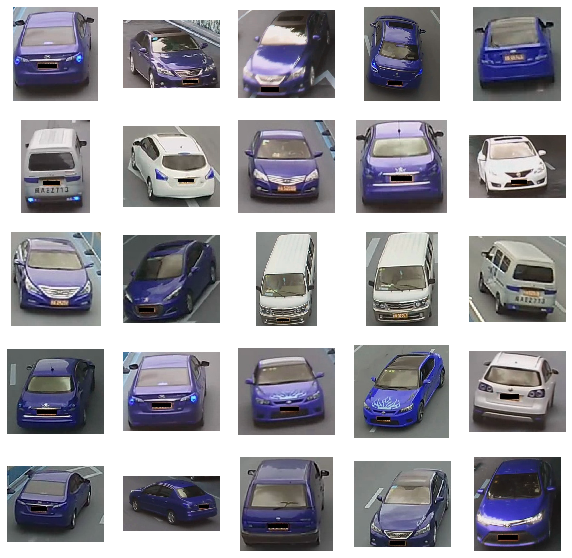

In [41]:
plot_faces()

Let's now add to that plot the facial keypoints that were tagged. First, let's do an example :

In [9]:
keypoint_cols = list(df.columns)[1:-1]

In [10]:
def xy_plotfilter(xy):
    y = np.empty((0,2))

    for x in xy:
        if x[0]!=-1 and x[1]!=-1:
            y = np.append(y,[x],axis=0)
    return y

In [11]:
xy = df.iloc[0][keypoint_cols].values.reshape((20, 2))

xy = xy_plotfilter(xy)
print(xy) 

[[367 89]
 [190 205]
 [315 59]
 [267 35]
 [185 8]
 [101 46]
 [183 77]
 [14 148]
 [91 180]
 [44 160]
 [46 176]]


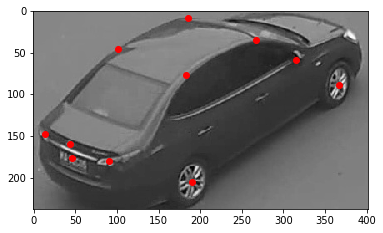

In [12]:
plt.plot(xy[:, 0], xy[:, 1], 'ro')
plt.imshow(string2image(df.iloc[0][0]), cmap='gray')

Now, let's add this to the function we wrote before.

In [13]:
def plot_faces_with_keypoints(nrows=5, ncols=5):
    """Randomly displays some faces from the training data with their keypoints."""
    selection = np.random.choice(df.index, size=(nrows*ncols), replace=False)
    image_strings = df.loc[selection][0]
    keypoint_cols = list(df.columns)[1:-1]
    keypoints = df.loc[selection][keypoint_cols]
    fig, axes = plt.subplots(figsize=(10, 10), nrows=nrows, ncols=ncols)
    for string, (iloc, keypoint), ax in zip(image_strings, keypoints.iterrows(), axes.ravel()):
        xy = keypoint.values.reshape((20, 2))
        xy = xy_plotfilter(xy)
        ax.imshow(string2image(string), cmap='gray')
        ax.plot(xy[:, 0], xy[:, 1], 'ro')
        ax.axis('off')

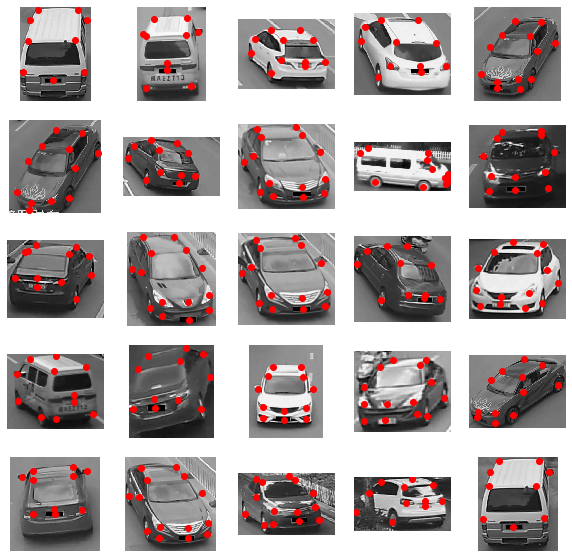

In [14]:
plot_faces_with_keypoints()

We can make several observations from this image: 

- some images are high resolution, some are low
- some images have all 15 keypoints, while some have only a few

Let's do some statistics about the keypoints to investigate that last observation :

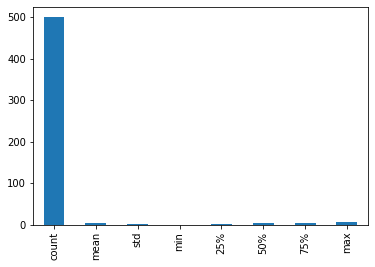

In [15]:
df.describe().loc[:][41].plot.bar()

What this plot tells us is that in this dataset, only 2000 images are "high quality" with all keypoints, while 5000 other images are "low quality" with only 4 keypoints labelled.

Let's start training the data with the high quality images and see how far we get.

In [16]:
fully_annotated = df.dropna()

In [17]:
fully_annotated.shape

(499, 42)

In [18]:
fully_annotated.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,VeRi/image_train/0181_c001_00034295_0.jpg,-1,-1,-1,-1,367,89,190,205,-1,...,77,14,148,91,180,44,160,46,176,7
1,VeRi/image_train/0181_c001_00034315_0.jpg,-1,-1,-1,-1,231,58,153,132,-1,...,32,14,94,108,108,55,100,58,114,7
2,VeRi/image_train/0181_c001_00034340_0.jpg,-1,-1,-1,-1,130,56,114,92,-1,...,19,18,64,96,69,55,62,54,72,7
3,VeRi/image_train/0181_c012_00034760_0.jpg,-1,-1,-1,-1,213,71,163,141,-1,...,44,22,100,123,113,67,106,70,123,7
4,VeRi/image_train/0181_c012_00034765_0.jpg,-1,-1,-1,-1,192,66,151,124,-1,...,36,25,89,116,97,68,93,73,108,7


# Building a Keras model 

Now on to the machine learning part. Let's build a Keras model with our data. Actually, before we do that, let's do some preprocessing first, using the scikit-learn pipelines (inspired by [this great post on scalable Machine Learning by Tom Augspurger](https://tomaugspurger.github.io/scalable-ml-01.html)).

The idea behind pipelining is that it allows you to easily keep track of the data transformations applied to our data. We need two scalings: one for the input and one for the output. Since I couldn't get the scaling to work for 3d image data, we will only use a pipeline for our outputs.

In [19]:
X = []
i = 0
y = np.vstack(fully_annotated[fully_annotated.columns[1:-1]].values)
for string in fully_annotated[:][0]:
    img = string2image(string)
    for j in range(0,40,2):
        if y[i][j] != -1:
            y[i][j] = y[i][j] / img.shape[1] * 336
        if y[i][j+1] != -1:
            y[i][j+1] = y[i][j+1] / img.shape[0] * 336
    img = cv2.resize(img,(336,336))
    X.append(img)
    #print(img.shape)
    #X = np.stack((X,[img])).astype(np.float)[:, :, :, np.newaxis]
    #X = np.concatenate((X,img)).astype(np.float)[:, :, :, np.newaxis]
    i+=1
X = np.array(X)
X = X.reshape(499, 336,336,1)
X.shape

#X = np.stack([cv2.resize(string2image(string),(336,336)) for string in fully_annotated[:][0]]).astype(np.float)[:, :, :, np.newaxis]

(499, 336, 336, 1)

In [20]:
for i in range(0,5):
    print(y[i])

[ -1  -1  -1  -1 306 125 158 289  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1
  -1  -1  -1  -1 263  83 223  49 154  11  84  64 152 108  11 208  76 254
  36 225  38 248]
[ -1  -1  -1  -1 318 121 210 275  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1
  -1  -1  -1  -1 291  58 236  18 128   4  82  48 196  66  19 196 148 225
  75 208  79 237]
[ -1  -1  -1  -1 314 165 275 271  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1
  -1  -1  62  50 314  64 256  20  99  14  79  50 241  56  43 188 232 203
 132 182 130 212]
[ -1  -1  -1  -1 307 140 235 278  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1
  -1  -1  93  41 294  75 248  35 118  21  83  65 214  86  31 197 177 223
  96 209 100 243]
[ -1  -1  -1  -1 286 134 225 252  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1
  -1  -1  83  40 274  67 235  32 110  20  83  52 207  73  37 181 173 197
 101 189 109 219]


In [21]:
xy1 = y[1].reshape((20, 2))
xy1 = xy_plotfilter(xy1)
xy1

array([[318., 121.],
       [210., 275.],
       [291.,  58.],
       [236.,  18.],
       [128.,   4.],
       [ 82.,  48.],
       [196.,  66.],
       [ 19., 196.],
       [148., 225.],
       [ 75., 208.],
       [ 79., 237.]])

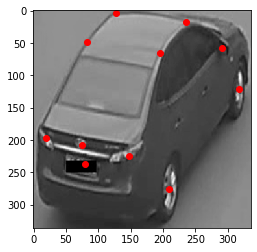

In [22]:
#keypoint_cols = list(df.columns)[1:-1]

plt.plot(xy1[:, 0], xy1[:, 1], 'ro')
img1 = string2image(fully_annotated[:][0][1])
img1 = cv2.resize(img1,(336,336))
plt.imshow(img1, cmap='gray')

In [23]:
X.shape, X.dtype

((499, 336, 336, 1), dtype('uint8'))

In [24]:
y.shape, y.dtype

((499, 40), dtype('int64'))

In [25]:
X_train = X / 255.0

In [26]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

output_pipe = make_pipeline(
    MinMaxScaler(feature_range=(-1, 1))
)

y_train = output_pipe.fit_transform(y)
y_train.shape

(499, 40)

In [27]:
for i in range(0,5):
    print(y_train[i])

[-1.         -1.         -1.         -1.          0.88343558 -0.18446602
  0.          0.84713376 -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.          0.6146789  -0.328
  0.47854785 -0.46236559  0.02649007 -0.87301587 -0.43143813 -0.23976608
 -0.05555556  0.26744186 -0.9266055   0.33121019 -0.53892216  0.63461538
 -0.76357827  0.65567766 -0.75316456  0.61165049]
[-1.         -1.         -1.         -1.          0.95705521 -0.21035599
  0.32704403  0.75796178 -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.          0.78593272 -0.528
  0.56435644 -0.79569892 -0.14569536 -0.94708995 -0.44481605 -0.42690058
  0.21604938 -0.22093023 -0.87767584  0.25477707 -0.10778443  0.44871795
 -0.514377    0.53113553 -0.49367089  0.54045307]
[-1.         -1.         -1.         -1.          0.93251534  0.07

# Transfer learning for 8 classes

In [28]:
#Importing the ResNet50 model
from keras.applications.resnet50 import ResNet50, preprocess_input

#Loading the ResNet50 model with pre-trained ImageNet weights
model = ResNet50(weights='imagenet', include_top=False, input_shape=(336, 336, 3))

W1130 23:10:07.787857 140373928044352 deprecation_wrapper.py:119] From /home/william/anaconda3/envs/tfcpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1130 23:10:07.816876 140373928044352 deprecation_wrapper.py:119] From /home/william/anaconda3/envs/tfcpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1130 23:10:07.823477 140373928044352 deprecation_wrapper.py:119] From /home/william/anaconda3/envs/tfcpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W1130 23:10:07.845628 140373928044352 deprecation_wrapper.py:119] From /home/william/anaconda3/envs/tfcpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_se

In [29]:
#Reshaping the training data
X_train_new = np.array([np.resize(X_train[i], (336, 336, 3)) for i in range(0, len(X_train))]).astype('float32')

#Preprocessing the data, so that it can be fed to the pre-trained ResNet50 model. 
resnet_train_input = preprocess_input(X_train_new)

#Creating bottleneck features for the training data
train_features = model.predict(resnet_train_input)

#Saving the bottleneck features
np.savez('resnet_features_train', features=train_features)

In [30]:
img = X_train_new[0:2]#.reshape(1, -1)
img1 = preprocess_input(img)
print(img1.shape)
print(resnet_train_input.shape)

(2, 336, 336, 3)
(499, 336, 336, 3)


In [56]:
#Reshaping the testing data
X_test_new = np.array([imresize(X_test[i], (336, 336, 3)) for i in range(0, len(X_test))]).astype('float32')

#Preprocessing the data, so that it can be fed to the pre-trained ResNet50 model.
resnet_test_input = preprocess_input(X_test_new)

#Creating bottleneck features for the testing data
test_features = model.predict(resnet_test_input)

#Saving the bottleneck features
np.savez('resnet_features_test', features=test_features)

NameError: name 'X_test' is not defined

In [96]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, GlobalAveragePooling2D

In [114]:
model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=(336,336,3)))
model.add(Dropout(0.3))
model.add(Dense(8, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_4 ( (None, 3)                 0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 3)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 32        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________


In [115]:
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])

In [33]:
y_train1 = np.vstack(fully_annotated[fully_annotated.columns[-1]].values)
y_train1 = np.resize(y_train1, (499))
num_classes = 8
from keras.utils import np_utils
y_train1 = np_utils.to_categorical(y_train1, num_classes)
y_train1

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [117]:
import keras
checkpointer = keras.callbacks.ModelCheckpoint(filepath='scratchmodel.best.hdf5', 
                               verbose=1,save_best_only=True)

In [118]:
model.fit(train_features, y_train1, batch_size=32, epochs=200,
          validation_split=0.2, callbacks=[checkpointer], verbose=1, shuffle=True)

ValueError: Error when checking input: expected global_average_pooling2d_4_input to have shape (336, 336, 3) but got array with shape (11, 11, 2048)

In [103]:
X_train[0:2].shape

(2, 336, 336, 1)

In [110]:
from keras.applications.resnet50 import ResNet50, preprocess_input
model_input_shape = (1,)+model.get_input_shape_at(0)[1:]
img = X_train_new[0:2]#.reshape(1, -1)
img1 = preprocess_input(X_train_new)
print(img1.shape)
#prediction = model.predict(img1)
#predictions = model.predict(img)
#xy_predictions = output_pipe.inverse_transform(predictions).reshape(20, 2)
#plt.imshow(X_train[2, :, :, 0], cmap='gray')
#plt.plot(xy_predictions[:, 0], xy_predictions[:, 1], 'b*')
#prediction
score  = model.evaluate(train_features, y_train1)
score[1]

(499, 336, 336, 3)
499/499 [==============================] - 1s 1ms/step


0.791583166810458

In [112]:
test_predictions = model.predict(X_train_new)

ValueError: Error when checking input: expected global_average_pooling2d_3_input to have shape (11, 11, 2048) but got array with shape (336, 336, 3)

In [31]:
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.applications.inception_v3 import InceptionV3
from keras.utils.np_utils import to_categorical

# Get the InceptionV3 model so we can do transfer learning
base_inception = InceptionV3(weights='imagenet', include_top=False, 
                             input_shape=(336, 336, 3))
                             
# Add a global spatial average pooling layer
out = base_inception.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
total_classes = 8
predictions = Dense(total_classes, activation='softmax')(out)

model = Model(inputs=base_inception.input, outputs=predictions)

# only if we want to freeze layers
for layer in base_inception.layers:
    layer.trainable = False
    
# Compile 
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy']) 
model.summary()

W1130 23:12:33.649125 140373928044352 deprecation_wrapper.py:119] From /home/william/anaconda3/envs/tfcpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3980: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

W1130 23:12:46.188709 140373928044352 deprecation_wrapper.py:119] From /home/william/anaconda3/envs/tfcpu/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 336, 336, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 167, 167, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 167, 167, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 167, 167, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [34]:
from keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 32
train_datagen = ImageDataGenerator( 
                                   rotation_range=0, 
                                   width_shift_range=0.2,
                                   height_shift_range=0.2, 
                                   horizontal_flip = 'false')
train_generator = train_datagen.flow(X_train_new, y_train1, shuffle=False, 
                                     batch_size=BATCH_SIZE, seed=1)
batch_size = BATCH_SIZE
train_steps_per_epoch = X_train_new.shape[0] // batch_size
#val_steps_per_epoch = x_val.shape[0] // batch_size

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              epochs=15, verbose=1)

W1130 23:14:17.456909 140373928044352 deprecation.py:323] From /home/william/anaconda3/envs/tfcpu/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/15
15/15 [==============================] - 66s 4s/step - loss: 1.9972 - acc: 0.2208
Epoch 2/15
15/15 [==============================] - 57s 4s/step - loss: 1.7412 - acc: 0.2945
Epoch 3/15
15/15 [==============================] - 59s 4s/step - loss: 1.6464 - acc: 0.3605
Epoch 4/15
15/15 [==============================] - 57s 4s/step - loss: 1.5584 - acc: 0.4535
Epoch 5/15
15/15 [==============================] - 57s 4s/step - loss: 1.4642 - acc: 0.5021
Epoch 6/15
15/15 [==============================] - 58s 4s/step - loss: 1.4143 - acc: 0.5501
Epoch 7/15
15/15 [==============================] - 56s 4s/step - loss: 1.3564 - acc: 0.5230
Epoch 8/15
15/15 [==============================] - 57s 4s/step - loss: 1.2873 - acc: 0.5515
Epoch 9/15
15/15 [==============================] - 57s 4s/step - loss: 1.2444 - acc: 0.5556
Epoch 10/15
15/15 [==============================] - 58s 4s/step - loss: 1.1553 - acc: 0.6224
Epoch 11/15
15/15 [==============================] - 57s 4s/step - lo

array([[4.8218969e-19, 5.7204437e-27, 0.0000000e+00, 9.9999201e-01,
        7.6653373e-15, 2.9607233e-30, 9.5904443e-25, 8.0103518e-06]],
      dtype=float32)

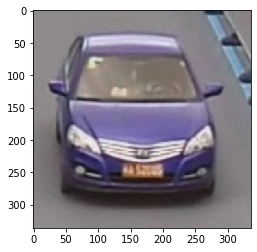

In [48]:
im = string2image(fully_annotated[:][0][9])
im = cv2.resize(im,(336,336))
plt.imshow(im)
im = np.expand_dims(im, axis =0)
img = X_train_new[0:2]#.reshape(1, -1)
#img1 = preprocess_input(X_train_new)
#print(img1.shape)
#prediction = model.predict(img1)
predictions = model.predict(im)
predictions

In this case, the pipelining process is, how to say this, not very spectacular. Let's move on and train a Keras model! We will start with a simple model, as found [in this blog post](http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/) with a fully connected layer and 100 hidden units.

In [41]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, Activation, MaxPooling2D, Dense, GlobalAveragePooling2D

Using TensorFlow backend.


In [42]:
model = Sequential()
model.add(Dense(100, activation="relu", input_shape=(336*336,)))
model.add(Activation('relu'))
model.add(Dense(8))

W1129 20:54:58.370776 139950289872704 deprecation_wrapper.py:119] From /home/william/anaconda3/envs/tfcpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1129 20:54:58.394842 139950289872704 deprecation_wrapper.py:119] From /home/william/anaconda3/envs/tfcpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1129 20:54:58.398083 139950289872704 deprecation_wrapper.py:119] From /home/william/anaconda3/envs/tfcpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Now let's compile the model and run the training.

In [43]:
from keras import optimizers

sgd = optimizers.SGD(lr=1e-5, decay=1e-4, momentum=0.9, nesterov=True)
adam = optimizers.Adam(lr=10e-3, beta_1=0.9, beta_2=0.999, amsgrad=True)

model.compile(optimizer=sgd, loss='mse', metrics=['accuracy'])
epochs = 100
history = model.fit(X_train.reshape(y_train.shape[0], -1), y_train, 
                 validation_split=0.2, shuffle=True, 
                 epochs=epochs, batch_size=20)

W1129 20:55:00.433584 139950289872704 deprecation_wrapper.py:119] From /home/william/anaconda3/envs/tfcpu/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1129 20:55:00.620710 139950289872704 deprecation_wrapper.py:119] From /home/william/anaconda3/envs/tfcpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W1129 20:55:00.650210 139950289872704 deprecation_wrapper.py:119] From /home/william/anaconda3/envs/tfcpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 399 samples, validate on 100 samples
Epoch 1/100
399/399 [==============================] - 3s 7ms/step - loss: 0.6493 - acc: 0.0677 - val_loss: 0.5912 - val_acc: 0.0000e+00
Epoch 2/100
399/399 [==============================] - 2s 5ms/step - loss: 0.5099 - acc: 0.0000e+00 - val_loss: 0.5340 - val_acc: 0.0000e+00
Epoch 3/100
399/399 [==============================] - 2s 5ms/step - loss: 0.4775 - acc: 0.0025 - val_loss: 0.5155 - val_acc: 0.0000e+00
Epoch 4/100
399/399 [==============================] - 2s 6ms/step - loss: 0.4643 - acc: 0.0050 - val_loss: 0.5085 - val_acc: 0.0000e+00
Epoch 5/100
399/399 [==============================] - 2s 5ms/step - loss: 0.4546 - acc: 0.0025 - val_loss: 0.5029 - val_acc: 0.0000e+00
Epoch 6/100
399/399 [==============================] - 2s 5ms/step - loss: 0.4476 - acc: 0.0025 - val_loss: 0.4995 - val_acc: 0.0000e+00
Epoch 7/100
399/399 [==============================] - 2s 5ms/step - loss: 0.4425 - acc: 0.0000e+00 - val_loss: 0.4972 - val_acc

399/399 [==============================] - 2s 5ms/step - loss: 0.3658 - acc: 0.0727 - val_loss: 0.4652 - val_acc: 0.0400
Epoch 62/100
399/399 [==============================] - 2s 5ms/step - loss: 0.3651 - acc: 0.0802 - val_loss: 0.4639 - val_acc: 0.0400
Epoch 63/100
399/399 [==============================] - 2s 5ms/step - loss: 0.3644 - acc: 0.0802 - val_loss: 0.4635 - val_acc: 0.0400
Epoch 64/100
399/399 [==============================] - 2s 5ms/step - loss: 0.3635 - acc: 0.0752 - val_loss: 0.4643 - val_acc: 0.0400
Epoch 65/100
399/399 [==============================] - 2s 5ms/step - loss: 0.3628 - acc: 0.0802 - val_loss: 0.4625 - val_acc: 0.0400
Epoch 66/100
399/399 [==============================] - 2s 5ms/step - loss: 0.3621 - acc: 0.0752 - val_loss: 0.4637 - val_acc: 0.0400
Epoch 67/100
399/399 [==============================] - 2s 5ms/step - loss: 0.3616 - acc: 0.0802 - val_loss: 0.4634 - val_acc: 0.0400
Epoch 68/100
399/399 [==============================] - 2s 5ms/step - loss:

Let's plot our training curves with this model.

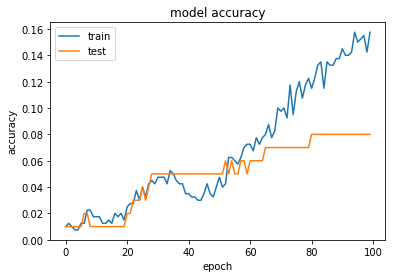

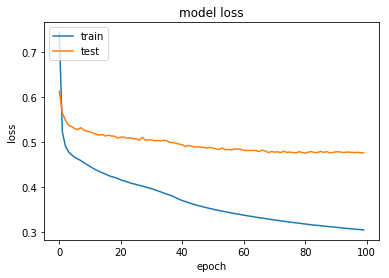

In [30]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

What we see here is that with this model, the learning quickly gets on a plateau. How can we improve this? There are a lot of options:

- adjust the optimizer settings
    - learning rate
    - batch size
    - momentum
- change the model

However, one things that is pretty clear from the above plot is that our model overfits: the train and test losses are not comparable (the test loss is 3 times higher). Let's see what the results of the net are on some samples from our data.

In [35]:
img = X_train[2, :, :, :].reshape(1, -1)
predictions = model.predict(img)

In [36]:
img

array([[0.34117647, 0.34117647, 0.34509804, ..., 0.44313725, 0.44705882,
        0.45098039]])

In [37]:
xy_predictions = output_pipe.inverse_transform(predictions).reshape(20, 2)

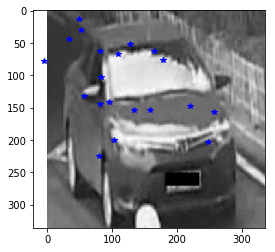

In [38]:
plt.imshow(X_train[2, :, :, 0], cmap='gray')
plt.plot(xy_predictions[:, 0], xy_predictions[:, 1], 'b*')

In [39]:
def plot_faces_with_keypoints_and_predictions(model, nrows=5, ncols=5, model_input='flat'):
    """Plots sampled faces with their truth and predictions."""
    selection = np.random.choice(np.arange(X.shape[0]), size=(nrows*ncols), replace=False)
    fig, axes = plt.subplots(figsize=(10, 10), nrows=nrows, ncols=ncols)
    for ind, ax in zip(selection, axes.ravel()):
        img = X_train[ind, :, :, 0]
        if model_input == 'flat':
            predictions = model.predict(img.reshape(1, -1))
        else:
            predictions = model.predict(img[np.newaxis, :, :, np.newaxis])
        xy_predictions = output_pipe.inverse_transform(predictions).reshape(20, 2)
        ax.imshow(img, cmap='gray')
        ax.plot(xy_predictions[:, 0], xy_predictions[:, 1], 'bo')
        ax.axis('off')

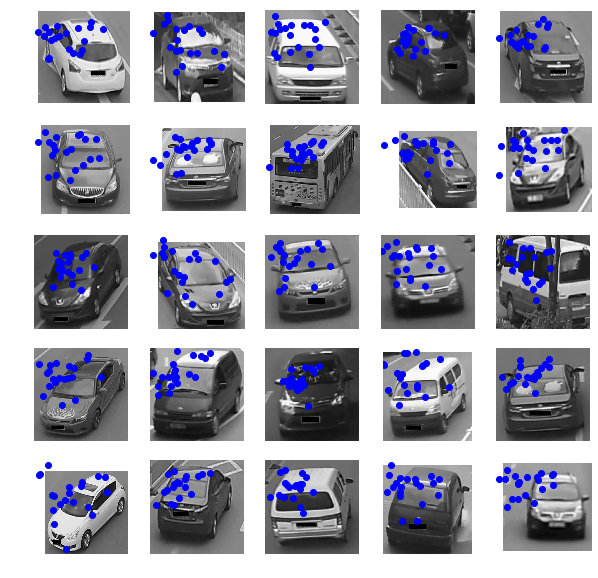

In [40]:
plot_faces_with_keypoints_and_predictions(model)

Actually, this looks pretty good already. Let's try to train a more complicated model, this time following the initial model description found in Peter Skvarenina's article.

# Towards more complicated models 

In [41]:
from keras.layers import Dropout, Flatten

In [43]:
import math, json, os, sys

import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing import image


DATA_DIR = 'VeRi'
TRAIN_DIR = os.path.join(DATA_DIR, 'image_train')
VALID_DIR = os.path.join(DATA_DIR, 'image_test')
SIZE = (336, 336)
BATCH_SIZE = 16



num_train_samples = sum([500 for r, d, files in os.walk(TRAIN_DIR)])
num_valid_samples = sum([50 for r, d, files in os.walk(VALID_DIR)])

num_train_steps = math.floor(num_train_samples/BATCH_SIZE)
num_valid_steps = math.floor(num_valid_samples/BATCH_SIZE)

gen = keras.preprocessing.image.ImageDataGenerator()
val_gen = keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True, vertical_flip=True)

batches = gen.flow_from_directory(TRAIN_DIR, target_size=SIZE, class_mode='categorical', shuffle=True, batch_size=BATCH_SIZE)
val_batches = val_gen.flow_from_directory(VALID_DIR, target_size=SIZE, class_mode='categorical', shuffle=True, batch_size=BATCH_SIZE)

model = keras.applications.resnet50.ResNet50()

classes = list(iter(batches.class_indices))
model.layers.pop()
for layer in model.layers:
    layer.trainable=False
last = model.layers[-1].output
x = Dense(len(classes), activation="softmax")(last)
finetuned_model = Model(model.input, x)
finetuned_model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
for c in batches.class_indices:
    classes[batches.class_indices[c]] = c
finetuned_model.classes = classes

early_stopping = EarlyStopping(patience=10)
checkpointer = ModelCheckpoint('resnet50_best.h5', verbose=1, save_best_only=True)

finetuned_model.fit_generator(batches, steps_per_epoch=num_train_steps, epochs=1000, callbacks=[early_stopping, checkpointer], validation_data=val_batches, validation_steps=num_valid_steps)
finetuned_model.save('resnet50_final.h5')

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
102858752/102853048 [==============================] - 9s 0us/step


AttributeError: 'Tensor' object has no attribute 'assign'

In [60]:
model = Sequential()
# input layer
model.add(BatchNormalization(input_shape=(336, 336, 1)))
model.add(Conv2D(24, (5, 5), kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))
# layer 2
model.add(Conv2D(36, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))
# layer 3
model.add(Conv2D(48, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))
# layer 4
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))
# layer 5
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(Flatten())
# layer 6
model.add(Dense(500, activation="relu"))
# layer 7
model.add(Dense(120, activation="relu"))
# layer 8
model.add(Dense(40))

In [61]:
sgd = optimizers.SGD(lr=1e-6, decay=1e-6, momentum=0.95, nesterov=True)
model.compile(optimizer=sgd, loss='mse', metrics=['accuracy'])
epochs = 110
history = model.fit(X_train, y_train, 
                 validation_split=0.2, shuffle=True, 
                 epochs=epochs, batch_size=10)

Train on 400 samples, validate on 100 samples
Epoch 1/110
400/400 [==============================] - 49s 123ms/step - loss: 0.8674 - acc: 0.0150 - val_loss: 0.6687 - val_acc: 0.0000e+00
Epoch 2/110
400/400 [==============================] - 56s 141ms/step - loss: 0.8432 - acc: 0.0200 - val_loss: 0.6574 - val_acc: 0.0000e+00
Epoch 3/110
400/400 [==============================] - 51s 126ms/step - loss: 0.8003 - acc: 0.0100 - val_loss: 0.6476 - val_acc: 0.0000e+00
Epoch 4/110
400/400 [==============================] - 51s 127ms/step - loss: 0.7700 - acc: 0.0100 - val_loss: 0.6398 - val_acc: 0.0000e+00
Epoch 5/110
400/400 [==============================] - 51s 127ms/step - loss: 0.7482 - acc: 0.0225 - val_loss: 0.6336 - val_acc: 0.0000e+00
Epoch 6/110
400/400 [==============================] - 50s 126ms/step - loss: 0.7278 - acc: 0.0175 - val_loss: 0.6285 - val_acc: 0.0000e+00
Epoch 7/110
400/400 [==============================] - 50s 124ms/step - loss: 0.7063 - acc: 0.0175 - val_loss: 0.6

KeyboardInterrupt: 

Let's see that in curves: 

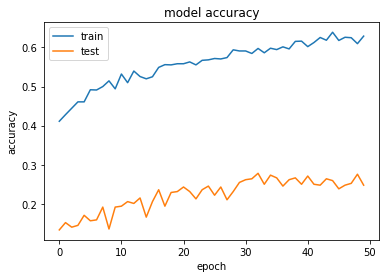

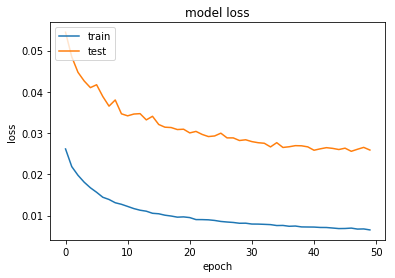

In [118]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

How good is the result?

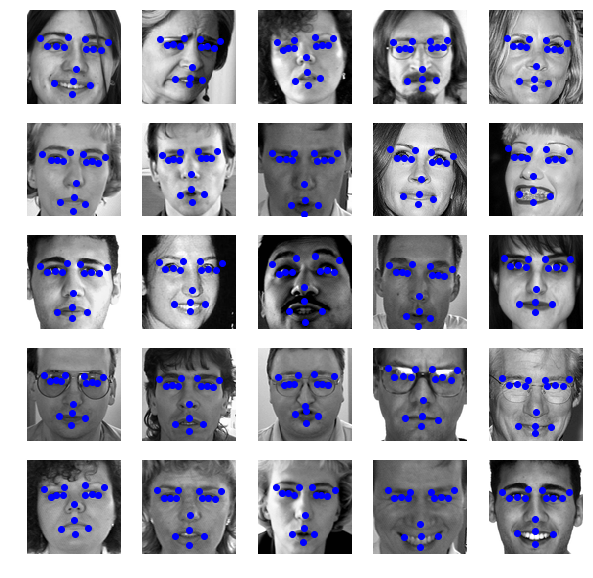

In [120]:
plot_faces_with_keypoints_and_predictions(model, model_input='2d')

If you ask me, that's already pretty good. Even though we didn't reach the performance advertised in Peter Skvarenina's blog post, with 80% validation accuracy. I wonder what he used to reach that level of performance: longer training? better settings? 

Let's move on to the last section of this blog post: applications.

# Applications 

## A face mask 

A first thing we can do is to apply some sort of mask on top of the detected image. Let's draw a moustache over an image for example. 

First, we need an image of a moustache.

In [175]:
import skimage.color
from skimage.filters import median

In [337]:
moustache = plt.imread('http://www.freeiconspng.com/uploads/moustache-png-by-spoonswagging-on-deviantart-1.png')
moustache = skimage.color.rgb2gray(moustache)

In [338]:
moustache = median(moustache, selem=np.ones((3, 3)))

/Users/kappamaki/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Let's display it.

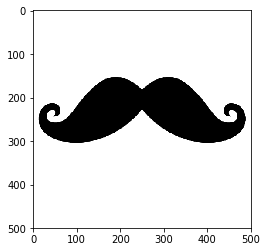

In [339]:
plt.imshow(moustache, cmap='gray')

Now, let's extract the boundary of this moustache.

In [340]:
from skimage import measure
moustache_contour = measure.find_contours(moustache, 0.8)[0]
moustache_contour -= np.array([250, 250])

Now, let's write a function that plots a scaled moustache at a given position.

In [368]:
def plot_scaled_moustache(ax, center_xy, dx):
    """Plots a moustache scaled by its width, dx, on current ax."""
    moustache_scaled = moustache_contour.copy()
    moustache_scaled -= moustache_contour.min(axis=0)
    moustache_scaled /= moustache_scaled.max(axis=0)[1]
    deltas = moustache_scaled.max(axis=0) - moustache_scaled.min(axis=0)
    moustache_scaled -= np.array([deltas[0]/2, deltas[1]/2])
    moustache_scaled *= dx
    moustache_scaled += center_xy[::-1]
    ax.fill(moustache_scaled[:, 1], moustache_scaled[:, 0], "g", linewidth=4)

Let's test this:

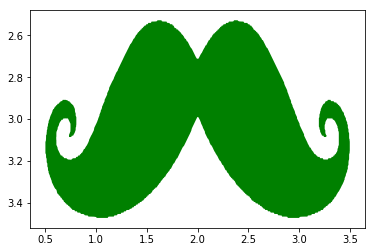

In [369]:
ax = plt.gca()
plot_scaled_moustache(ax, np.array([2, 3]), dx=3)
ax.invert_yaxis()

Finally, we can integrate this with a function of the predicted points. We will use the mouth location and space the moustache using the size of the mouth.

In [370]:
def draw_moustache(predicted_points, ax):
    """Draws a moustache using the predicted face points."""
    dx = 2 * np.linalg.norm(predicted_points[12, :] - predicted_points[11, :])
    center_xy = predicted_points[13, :]
    plot_scaled_moustache(ax, center_xy, dx)

Let's try this with the first image from the training set.

In [371]:
img = X_train[0, :, :, :][np.newaxis, :, :, :]
predictions = model.predict(img)
xy_predictions = output_pipe.inverse_transform(predictions).reshape(15, 2)

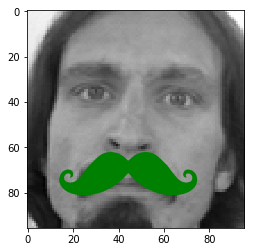

In [372]:
fig, ax = plt.subplots()
ax.imshow(X_train[0, :, :, 0], cmap='gray')
draw_moustache(xy_predictions, ax)

Ok, looks good. Let's apply this to a grid of images.

In [373]:
def plot_faces_with_moustaches(model, nrows=5, ncols=5, model_input='flat'):
    """Plots sampled faces with their truth and predictions."""
    selection = np.random.choice(np.arange(X.shape[0]), size=(nrows*ncols), replace=False)
    fig, axes = plt.subplots(figsize=(10, 10), nrows=nrows, ncols=ncols)
    for ind, ax in zip(selection, axes.ravel()):
        img = X_train[ind, :, :, 0]
        if model_input == 'flat':
            predictions = model.predict(img.reshape(1, -1))
        else:
            predictions = model.predict(img[np.newaxis, :, :, np.newaxis])
        xy_predictions = output_pipe.inverse_transform(predictions).reshape(15, 2)
        ax.imshow(img, cmap='gray')
        draw_moustache(xy_predictions, ax)
        ax.axis('off')

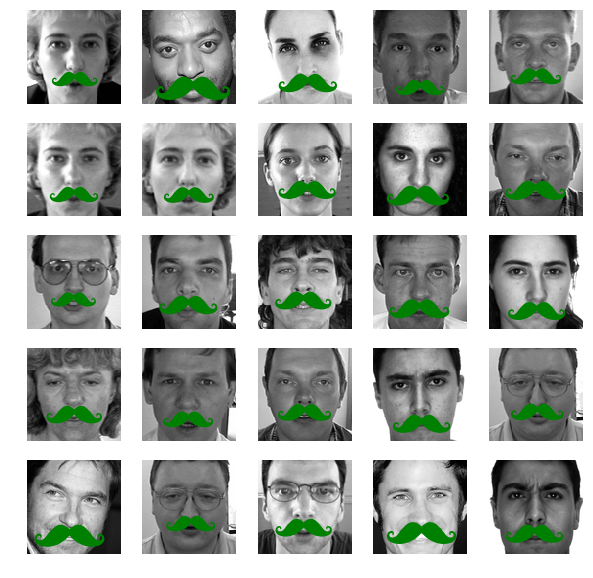

In [375]:
plot_faces_with_moustaches(model, model_input='2d')

This is fun. There's a couple of ways we could better: adjust for face directions (the tilted faces in particular look strange). But that's already pretty nice. Let's make a gallery of famous faces with moustaches.

## Famous faces with moustaches 

Let's apply the skill of adding automated moustaches to some famous paintings.

In [501]:
portrait_urls = ["https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/1024px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg",
                "https://upload.wikimedia.org/wikipedia/commons/thumb/d/d2/Hans_Holbein%2C_the_Younger_-_Sir_Thomas_More_-_Google_Art_Project.jpg/1280px-Hans_Holbein%2C_the_Younger_-_Sir_Thomas_More_-_Google_Art_Project.jpg",
                "https://upload.wikimedia.org/wikipedia/commons/b/b6/The_Blue_Boy.jpg",
                "https://upload.wikimedia.org/wikipedia/commons/thumb/2/2f/Thomas_Kerrich_%281748-1828%29%2C_by_Pompeo_Batoni.jpg/1280px-Thomas_Kerrich_%281748-1828%29%2C_by_Pompeo_Batoni.jpg",
                "https://upload.wikimedia.org/wikipedia/en/d/d6/GertrudeStein.JPG",
                "https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/Ambrogio_de_Predis_-_Girl_with_Cherries.jpg/1024px-Ambrogio_de_Predis_-_Girl_with_Cherries.jpg",
                "https://upload.wikimedia.org/wikipedia/commons/f/f8/Martin_Luther%2C_1529.jpg",
                "https://upload.wikimedia.org/wikipedia/commons/thumb/6/60/Pierre-Auguste_Renoir_110.jpg/1280px-Pierre-Auguste_Renoir_110.jpg"]

In [502]:
portraits = {}
for url in portrait_urls:
    if url not in portraits:
        portraits[url] = imread(url)

In [503]:
from skimage.io import imread
import cv2

/Users/kappamaki/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


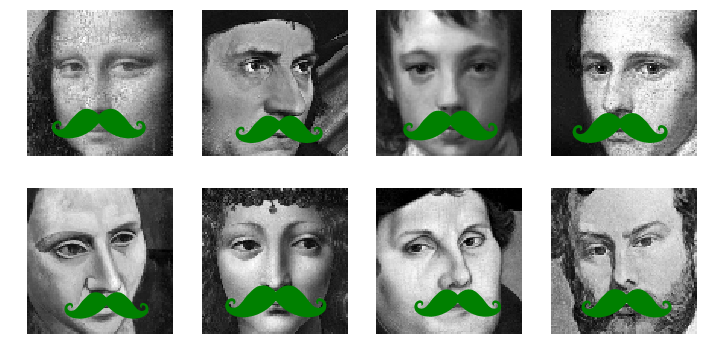

In [505]:
face_cascade = cv2.CascadeClassifier('data/haarcascade_frontalface_default.xml')
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
for img, ax in zip(portraits.values(), axes.ravel()):
    gray = (skimage.color.rgb2gray(img) * 255).astype(dtype='uint8')
    bounding_boxes = face_cascade.detectMultiScale(gray, 1.25, 6)
    for (x,y,w,h) in bounding_boxes:
        roi_gray = gray[y:y+h, x:x+w]
        roi_rescaled = skimage.transform.resize(roi_gray, (96, 96))
        predictions = model.predict(roi_rescaled[np.newaxis, :, :, np.newaxis])
        xy_predictions = output_pipe.inverse_transform(predictions).reshape(15, 2)
        ax.imshow(roi_rescaled, cmap='gray')
        draw_moustache(xy_predictions, ax)
    ax.axis('off')

For comparison's sake, here are the original paintings:

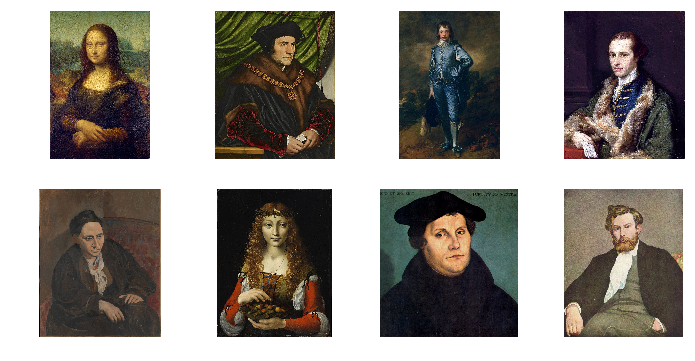

In [506]:
face_cascade = cv2.CascadeClassifier('data/haarcascade_frontalface_default.xml')
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
for img, ax in zip(portraits.values(), axes.ravel()):
    ax.imshow(img)
    ax.axis('off')

# Conclusions 

Okay, that's it for this blog post. So what steps did we go through? We trained a model using Kaggle data, Keras and a deep convolutional neural network. The model was good enough that we could apply it to images from the internet without major changes. 

After doing all this, I still feel that we only scratched the edge of what we could do with this. In particular, the neural network part was not very satisfying since I feel the model we trained could have been better. The reason I did not delve deeper into this (no pun intended) is that I don't own any GPU and hence the training takes quite a long time, which I was not willing to wait for better results. 

As a takeaway from this post, I think the claim that a high school genius could do things like these on his own is indeed true. If you have the data, it seems that the machine learning models are powerful and simple enough to allow you to do things that were much more complicated in the past. 

If I have time for a next post, I'd love to extend the work we did here but do transfer learning, using features from famous already trained neural networks.

*This post was entirely written using the IPython notebook. Its content is BSD-licensed. You can see a static view or download this notebook with the help of nbviewer at [20170914_FacialKeypointsDetection.ipynb](http://nbviewer.ipython.org/urls/raw.github.com/flothesof/posts/master/20170914_FacialKeypointsDetection.ipynb).*